In [2]:
import pandas as pd
import numpy as np
import regex as re
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dftest = pd.read_csv("test.csv")
print(dftest.head())

dftrain = pd.read_csv("train.csv")
print(dftrain.head())
print(len(dftest))


       id     Name  Gender   Age           City  \
0  140700   Shivam    Male  53.0  Visakhapatnam   
1  140701    Sanya  Female  58.0        Kolkata   
2  140702     Yash    Male  53.0         Jaipur   
3  140703   Nalini  Female  23.0         Rajkot   
4  140704  Shaurya    Male  47.0         Kalyan   

  Working Professional or Student              Profession  Academic Pressure  \
0            Working Professional                   Judge                NaN   
1            Working Professional  Educational Consultant                NaN   
2            Working Professional                 Teacher                NaN   
3                         Student                     NaN                5.0   
4            Working Professional                 Teacher                NaN   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            2.0   NaN                 NaN               5.0   
1            2.0   NaN                 NaN               4.0   
2            4.0   N

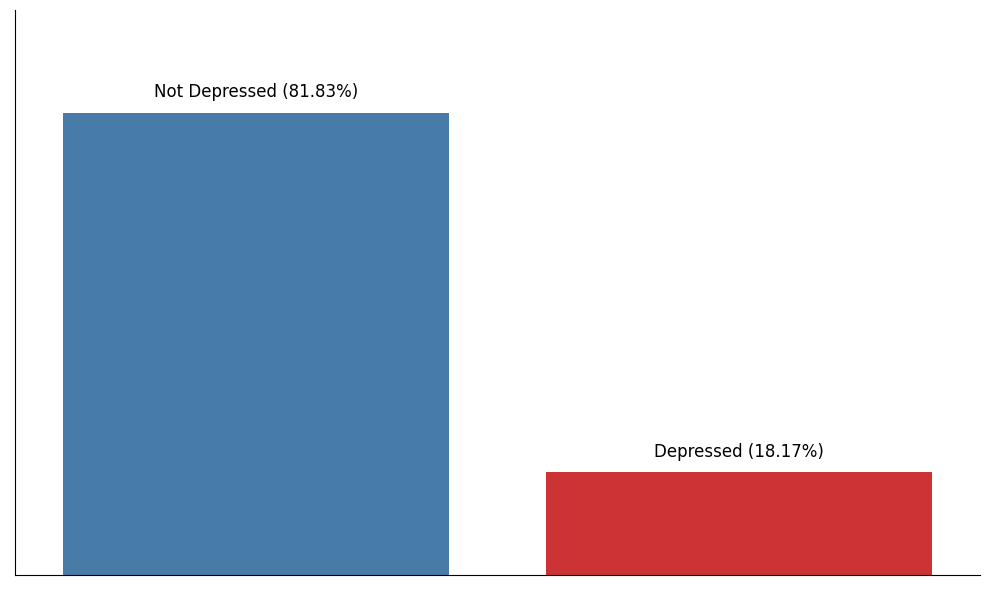

In [3]:
depression_counts = dftrain.Depression.value_counts(normalize=True).reset_index()
depression_counts.columns = ['Depression', 'Proportion']
palette = {0: sns.color_palette("Set1")[1], 1: sns.color_palette("Set1")[0]}
class_mapping = {0: 'Not Depressed', 1: 'Depressed'}

plt.figure(figsize=(10, 6))
sns.barplot(x='Depression', y='Proportion', data=depression_counts, palette=palette)

plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(0, 1)

for index, row in depression_counts.iterrows():
    plt.text(row.name, row.Proportion + 0.02, f'{class_mapping[row.name]} ({row.Proportion:.2%})', ha='center', va='bottom', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [20]:
cat_cols = dftrain.select_dtypes(include='object').columns.tolist()
palette = {0: sns.color_palette("Set1")[1], 1: sns.color_palette("Set1")[0]}

fig, axes = plt.subplots(5, 2, figsize=(60, 100))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.countplot(data=dftrain, x=col, hue = 'Depression', ax=axes[i], palette=palette)
    axes[i].set_title(f'{col} distribution')
    axes[i].set_ylabel('')
    axes[i].set_xlabel(col, fontsize=5)
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

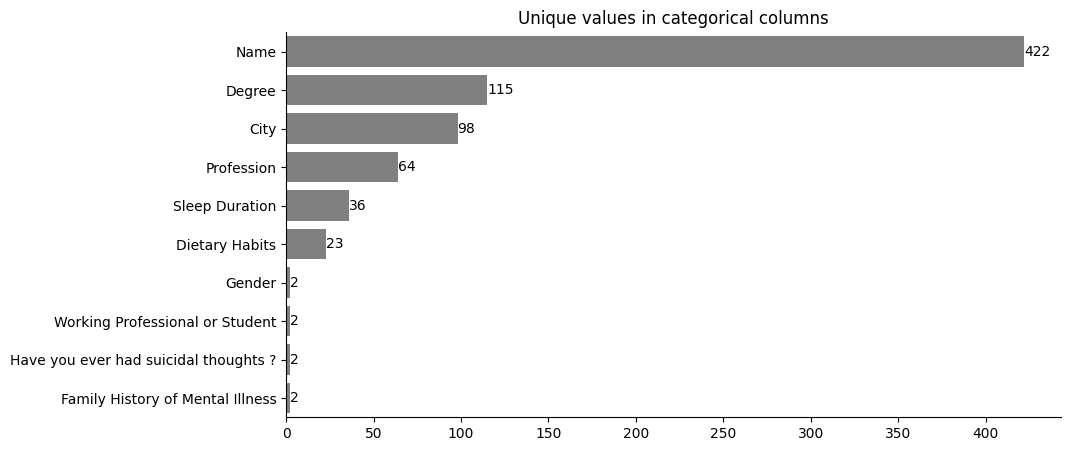

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(
    x=dftrain[cat_cols].nunique().sort_values(ascending=False).values,
    y=dftrain[cat_cols].nunique().sort_values(ascending=False).index,
    ax=ax,
    color="grey"
)
ax.set_title('Unique values in categorical columns')

for i, value in enumerate(dftrain[cat_cols].nunique().sort_values(ascending=False).values):
    ax.text(value, i, f'{value}', va='center')

sns.despine()
plt.show()

In [3]:
# rename columns in both datasets:
dftrain.rename(columns={"Working Professional or Student": "WorkingStudent",
"Academic Pressure": "AcademicPressure","Work Pressure": "WorkPressure",
"Study Satisfaction": "studySatisf","Job Satisfaction": "jobSatisf","Sleep Duration": "sleepDur",
"Dietary Habits": "dietaryHabits","Have you ever had suicidal thoughts ?": "thoughts",
"Work/Study Hours": "hours","Financial Stress": "financialStress",
"Family History of Mental Illness": "familyHist"}, inplace=True)
dftest.rename(columns={"Working Professional or Student": "WorkingStudent",
"Academic Pressure": "AcademicPressure","Work Pressure": "WorkPressure",
"Study Satisfaction": "studySatisf","Job Satisfaction": "jobSatisf","Sleep Duration": "sleepDur",
"Dietary Habits": "dietaryHabits","Have you ever had suicidal thoughts ?": "thoughts",
"Work/Study Hours": "hours","Financial Stress": "financialStress",
"Family History of Mental Illness": "familyHist"}, inplace=True)

print(dftrain.head(5))

print(len(dftest))

   id      Name  Gender   Age           City        WorkingStudent  \
0   0  Aaradhya  Female  49.0       Ludhiana  Working Professional   
1   1     Vivan    Male  26.0       Varanasi  Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam               Student   
3   3    Yuvraj    Male  22.0         Mumbai  Working Professional   
4   4      Rhea  Female  30.0         Kanpur  Working Professional   

         Profession  AcademicPressure  WorkPressure  CGPA  studySatisf  \
0              Chef               NaN           5.0   NaN          NaN   
1           Teacher               NaN           4.0   NaN          NaN   
2               NaN               5.0           NaN  8.97          2.0   
3           Teacher               NaN           5.0   NaN          NaN   
4  Business Analyst               NaN           1.0   NaN          NaN   

   jobSatisf           sleepDur dietaryHabits   Degree thoughts  hours  \
0        2.0  More than 8 hours       Healthy      BHM      

In [4]:
# make the hours slept from string to a number and delete all the nonsense
def cleanHours(s):
    if not bool(re.search(r'\d', s)): return None
    if int(re.search(r'\d+', s).group()) >= 12: return None
    return s

def preprocess_sleep(s):
    if s == None:
        return None
    else:
        if "More than" in s: return 9
        if "Less than" in s: return 4.5
        if match := re.search(r'(\d+)-(\d+)', s): return (int(match[1]) + int(match[2])) / 2
        if match := re.search(r'\d+', s): return int(match[0])
    return s


In [5]:

print(dftrain["sleepDur"].value_counts)
print(len(dftrain))
# Apply Functions for training set
dftrain['sleepDur'] = dftrain['sleepDur'].apply(cleanHours)
dftrain['sleepDur'] = dftrain['sleepDur'].apply(preprocess_sleep)

print(dftrain["sleepDur"].value_counts)
print(len(dftrain))

print(dftest["sleepDur"].value_counts)
print(len(dftest))
# Apply Functions for test set
dftest['sleepDur'] = dftest['sleepDur'].apply(cleanHours)
dftest['sleepDur'] = dftest['sleepDur'].apply(preprocess_sleep)

print(dftest["sleepDur"].value_counts)
print(len(dftest))

<bound method IndexOpsMixin.value_counts of 0         More than 8 hours
1         Less than 5 hours
2                 5-6 hours
3         Less than 5 hours
4                 5-6 hours
                ...        
140695            5-6 hours
140696            7-8 hours
140697    More than 8 hours
140698            5-6 hours
140699    Less than 5 hours
Name: sleepDur, Length: 140700, dtype: object>
140700
<bound method IndexOpsMixin.value_counts of 0         9.0
1         4.5
2         5.5
3         4.5
4         5.5
         ... 
140695    5.5
140696    7.5
140697    9.0
140698    5.5
140699    4.5
Name: sleepDur, Length: 140700, dtype: float64>
140700
<bound method IndexOpsMixin.value_counts of 0        Less than 5 hours
1        Less than 5 hours
2                7-8 hours
3        More than 8 hours
4                7-8 hours
               ...        
93795    Less than 5 hours
93796            7-8 hours
93797            7-8 hours
93798            5-6 hours
93799    More than 8 hours


In [6]:
#check which values exist in both data frames 
print(dftest["sleepDur"].unique())
print(dftrain['sleepDur'].unique())

for c in dftest.columns: 
    print(c)
    print(dftrain[c].unique())
    print('df test: ----------------------------------------------------------')
    print(dftest[c].unique())

[ 4.5  7.5  9.   5.5  0.   nan  7.   6.5  3.5  8.5  5.   1.5 48.5  8.
  2.   6.   2.5 10.   9.5]
[ 9.   4.5  5.5  7.5  nan  1.5  7.   5.   6.5 10.5  8.5 10.   2.5  3.5
  2.   8. ]
id
[     0      1      2 ... 140697 140698 140699]
df test: ----------------------------------------------------------
[140700 140701 140702 ... 234497 234498 234499]
Name
['Aaradhya' 'Vivan' 'Yuvraj' 'Rhea' 'Vani' 'Ritvik' 'Rajveer' 'Aishwarya'
 'Simran' 'Utkarsh' 'Aahana' 'Tejas' 'Aadhya' 'Kiran' 'Aditi' 'Suhani'
 'Jiya' 'Bhavesh' 'Armaan' 'Ishaani' 'Prachi' 'Pratyush' 'Abhinav'
 'Siddhesh' 'Aditya' 'Aarav' 'Asha' 'Kashish' 'Prisha' 'Chhavi' 'Tanmay'
 'Vihaan' 'Shiv' 'Anvi' 'Darsh' 'Samar' 'Raunak' 'Mahi' 'Shaurya' 'Vidya'
 'Jai' 'Ayush' 'Ansh' 'Anand' 'Yashvi' 'Shrey' 'Ritika' 'Mihir' 'Isha'
 'Arjun' 'Rohan' 'Pratham' 'Nirvaan' 'Ishaan' 'Aarya' 'Riya' 'Aariv'
 'Raghavendra' 'Mahika' 'Abhishek' 'Harshil' 'Janvi' 'Kartikeya' 'Shivam'
 'Advait' 'Reyansh' 'Saanvi' 'Ivaan' 'Pallavi' 'Sneha' 'Ayaan' 'Aakash'
 'R

In [7]:
# cleanup the dataframe: 

# Function to check if a string contains numbers
def contains_numbers(s):
    if pd.isna(s):
        return False
    return bool(re.search(r'\d+', str(s)))

# Function to filter rows based on whether they contain numbers
def delete_rows_with_numbers(s,x):
    if s == None or pd.isna(s):
        return None
    match = re.search(r'\d+', s)
    if match: 
        if int(match.group()) >=x: return None
    return s

def delete_rows_with_values(s):
    valuesToDelete = ['MSc','ME', 'No','M.Com','B.Com', 'BE', 'Pratham','BSc','Gender','Mihir','M.Tech','Vegas','No','Male','Indoor','City'
                    ,'Pranav']
    if s == None or pd.isna(s):
        return None
    if s in valuesToDelete: return None
    return s

def dietaryHabits(s):
    
    if pd.isna(s):
        return None
    s = str(s).lower()  
    
       # Check for different conditions
    if 'healthy' in s and 'no' not in s or '4' in s or '5'in s:
        return 'Healthy'
    elif 'unhealthy' in s or 'no healthy' in s or '1' in s or '2'in s:
        return 'Unhealthy'
    elif 'moderate' in s or 'less healthy' in s or 'less than healthy' in s or '3' in s:
        return 'Moderate'
    return None


In [8]:
#apply all the functions on train set
dftrainproc = dftrain
dftrainproc['dietaryHabits'] = dftrain['dietaryHabits'].apply(lambda s: delete_rows_with_numbers(s, 6))
dftrainproc['Degree'] = dftrainproc['Degree'].apply(lambda s: delete_rows_with_numbers(s, 0)) 
dftrainproc['City'] = dftrainproc['City'].apply(lambda s: delete_rows_with_numbers(s, 0))
dftrainproc["dietaryHabits"] = dftrainproc["dietaryHabits"].apply(dietaryHabits)

dftrainproc['City'] = dftrainproc['City'].apply(delete_rows_with_values)
dftrainproc['Profession'] = dftrainproc['Profession'].apply(delete_rows_with_values)
 
#apply all the functions on test set
dftestproc = dftest
dftestproc['dietaryHabits'] = dftest['dietaryHabits'].apply(lambda s: delete_rows_with_numbers(s, 6))
dftestproc['Degree'] = dftestproc['Degree'].apply(lambda s: delete_rows_with_numbers(s, 0)) 
dftestproc['City'] = dftestproc['City'].apply(lambda s: delete_rows_with_numbers(s, 0))
dftestproc["dietaryHabits"] = dftestproc["dietaryHabits"].apply(dietaryHabits)

dftestproc['City'] = dftestproc['City'].apply(delete_rows_with_values)
dftestproc['Profession'] = dftestproc['Profession'].apply(delete_rows_with_values)


In [9]:
print(dftrainproc.dtypes)
label_encoder = LabelEncoder()
dftrainproc['dietaryHabits'] = label_encoder.fit_transform(dftrainproc['dietaryHabits'])

columns_to_encode = ['Gender', 'City', 'WorkingStudent','Profession','Degree','thoughts','familyHist']

# Apply One-Hot Encoding to the specified columns in both train
dftrainproc = pd.get_dummies(dftrainproc, columns=columns_to_encode, drop_first=True)  # Drop the first to avoid multicollinearity

dftrainproc = dftrainproc.drop('Name', axis=1)


print(dftest.columns)
dftest['dietaryHabits'] = label_encoder.fit_transform(dftest['dietaryHabits'])

columns_to_encode = ['Gender', 'City', 'WorkingStudent','Profession','Degree','thoughts','familyHist',"sleepDur"]

# Apply One-Hot Encoding to the specified columns data
dftest = pd.get_dummies(dftest, columns=columns_to_encode, drop_first=True)  # Drop the first to avoid multicollinearity

dftest = dftest.drop('Name', axis=1)

print(dftest.dtypes)

id                    int64
Name                 object
Gender               object
Age                 float64
City                 object
WorkingStudent       object
Profession           object
AcademicPressure    float64
WorkPressure        float64
CGPA                float64
studySatisf         float64
jobSatisf           float64
sleepDur            float64
dietaryHabits        object
Degree               object
thoughts             object
hours               float64
financialStress     float64
familyHist           object
Depression            int64
dtype: object
Index(['id', 'Name', 'Gender', 'Age', 'City', 'WorkingStudent', 'Profession',
       'AcademicPressure', 'WorkPressure', 'CGPA', 'studySatisf', 'jobSatisf',
       'sleepDur', 'dietaryHabits', 'Degree', 'thoughts', 'hours',
       'financialStress', 'familyHist'],
      dtype='object')
id                    int64
Age                 float64
AcademicPressure    float64
WorkPressure        float64
CGPA                float64

In [10]:
#since df_test does not contain the labels, in order to locally test the predictor I split the train dataframe
# into train and testing. Also this is what was used to find the best parameters for the predictor.


#X_train = dftrainproc.drop(columns=['Depression'])  
#y_train = dftrainproc['Depression']  


# # Create the LightGBM dataset
# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# # Set LightGBM parameters (you can tune these parameters later)
# params = {
#     'objective': 'binary',  # Use 'multiclass' for multi-class classification
#     'metric': 'binary_error',  # Use 'multi_logloss' for multi-class
#     'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
#     'num_leaves': 50,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9
# }


# # Train the model
# clf = lgb.train(params, train_data, valid_sets=test_data, num_boost_round=200)


In [11]:
# Make predictions
# y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)

# # For binary classification, we can convert probabilities to binary labels
# y_pred_binary = (y_pred > 0.5).astype(int)

# # Evaluate accuracy
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Accuracy: {accuracy:.4f}")


In [12]:
#Finds the best parameters for the model. 

# from sklearn.model_selection import GridSearchCV

# # Set parameter grid for tuning
# param_grid = {
#     'num_leaves': [31, 50, 100],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200]
# }

# # Initialize the LightGBM classifier
# lgbm = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='binary_error')

# # Perform GridSearchCV
# grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy found: ", grid_search.best_score_)


In [13]:
#Here I train the model on all the data in the train dataset, without splits.
# Separate features and target (replace 'target_column' with your actual target column name)
X_train = dftrainproc.drop(columns=['Depression'])
y_train = dftrainproc['Depression']

params = {
    'objective': 'binary',  # Use 'multiclass' for multi-class classification
    'metric': 'binary_logloss',  # Use 'multi_logloss' for multi-class
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 200,
    'learning_rate': 0.01,
    'feature_fraction': 0.9
}

clf = lgb.train(
    params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=10000,
    valid_sets=[lgb.Dataset(X_train, label=y_train)],
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25567, number of negative: 115133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 140700, number of used features: 106
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181713 -> initscore=-1.504786
[LightGBM] [Info] Start training from score -1.504786


In [14]:
#  'clf' is  trained model and 'df_test' is  test DataFrame

# Step 1: Prepare the test data (remove target column if exists)
X_test = dftest  # dftest has no 'Depression' column

# Step 2: Predict using  trained model
y_pred = clf.predict(X_test,predict_disable_shape_check=True)  # This gives the predicted values (0 or 1 for binary classification)

predictions_class = (y_pred >= 0.5).astype(int)  # Applying threshold of 0.5
print(predictions_class)
# Step 3: Prepare the submission file
submission = pd.DataFrame({
    'id': dftest['id'],  # Assuming 'id' column is present in your test data
    'Depression': predictions_class  # The predicted depression levels (0 or 1)
})
print(submission.head())
print(len(submission))
print(submission["Depression"].unique())
# Step 4: Save the submission file to CSV
# Open the file explicitly in write mode
with open('submission.csv', 'w') as f:
    submission.to_csv(f, index=False,encoding='utf-8')

print("Submission file has been created: submission_file.csv")


[0 0 0 ... 0 0 0]
       id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0
93800
[0 1]
Submission file has been created: submission_file.csv
